In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

### Functions used in this code
import density_functions as dfunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=clndr16['RA']*u.degree, dec=clndr16['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

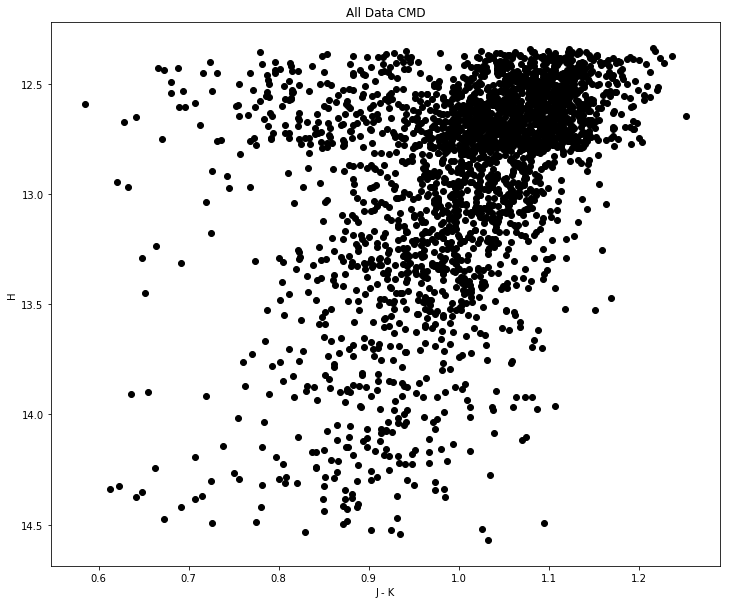

In [3]:
###########
### CMD ###
###########

plt.figure(figsize=[12,10])
plt.scatter(clndr16['J']-clndr16['K'],clndr16['H'],c='k')
plt.gca().invert_yaxis()
plt.ylabel(r'H')
plt.xlabel(r'J - K')
plt.title(r'All Data CMD')
plt.savefig('alladataCMD.pdf',bbox_inches='tight')
plt.show()

In [4]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [5]:
### blue loop cut
bloop = np.where((clndr16['TEFF']>=4100)&(clndr16['H']<=13.0)&((clndr16['J']-clndr16['K'])<=0.95))

bloop_cut = []
for i in range(len(clndr16)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
bloopdr16 = clndr16[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopdr16['FIELD']==field_str[i]))

#fnt and brt bins
fbins = dfunc.brtfntlmc_bins(bloopdr16)

In [6]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = dfunc.LMCdisk_cart(clndr16['RA'],clndr16['DEC'])
corabsK = dfunc.absmag(clndr16['K'],stardist)-clndr16['AK_TARG']
parage = dfunc.parsec_age(np.log10(clndr16['TEFF']),corabsK,dfunc.sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

#bloop cut ages
bloopage = parage[bloop_cut]
bloopabsH = (dfunc.absmag(clndr16['H'],stardist)-clndr16['AK_TARG'])[bloop_cut]

In [8]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in tqdm_notebook(range(len(clndr16)),desc='Done?'):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = dfunc.noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(dfunc.parsec_age(nlgT,nks,dfunc.sal(nmh,nfac),nlgg))
    
    devs.append(dfunc.mad(ages))
    
bloopage_devs = np.asarray(devs)[bloop_cut]

In [9]:
########################
### Area Calculation ###
########################

### pc^2
field_ang = [0.8,0.95,0.95,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.95,0.8,0.8,0.8,0.95,0.8]
field_areas = np.multiply(np.pi*np.square(np.multiply(field_ang,0.875)),10**6)

In [10]:
field_areas

array([1539380.400259  , 2170766.89255273, 2170766.89255273,
       1539380.400259  , 1539380.400259  , 1539380.400259  ,
       1539380.400259  , 1539380.400259  , 1539380.400259  ,
       1539380.400259  , 1539380.400259  , 1539380.400259  ,
       2170766.89255273, 1539380.400259  , 1539380.400259  ,
       1539380.400259  , 2170766.89255273, 1539380.400259  ])

In [29]:
### Calculate the fields masses

iso_ages = []
iso_zs = []

for i in range(len(field_str)):
    fd = np.where(bloopdr16['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(bloopage[fd]),np.median(bloopdr16[fd]['FE_H']))
    iso_ages.append(age)
    iso_zs.append(z)

absHs = []
for i in range(len(field_str)):
    field_H = np.where(bloopdr16['FIELD']==field_str[i]) 
    absHs.append(np.asarray(bloopabsH)[field_H])

sf_brites = []
sf_faints = []
for i,j in enumerate(fbins):
    if i in np.arange(len(fbins))[1::2]:
        sf_brites.append(bloopdr16[fbins[j]]['SELECTFUNC'])
    if i in np.arange(len(fbins))[0::2]:
        sf_faints.append(bloopdr16[fbins[j]]['SELECTFUNC'])
        
field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    field_masses.append(dfunc.fieldmass(iso_ages[i],iso_zs[i],absHs[i],sf_brites[i],sf_faints[i],parsec))
print(field_masses)


[32922504.78638458, 5235791.9555795435, 4476266.407626547, 13833653.180144247, 56206779.997921914, 61175256.62210889, 39690021.68117715, 24875723.49604724, 52101396.25089198, 264285467.5838225, 24425689.90244778, 29276313.839029837, 2929418.777764781, 49404573.35900116, 73843791.16896236, 149006069.71862063, 6978434.898802554, 22058411.474356644]


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   18
Model:                            RLM   Df Residuals:                       16
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 11 Mar 2020                                         
Time:                        16:53:43                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0260      0.411     12.242      0.0

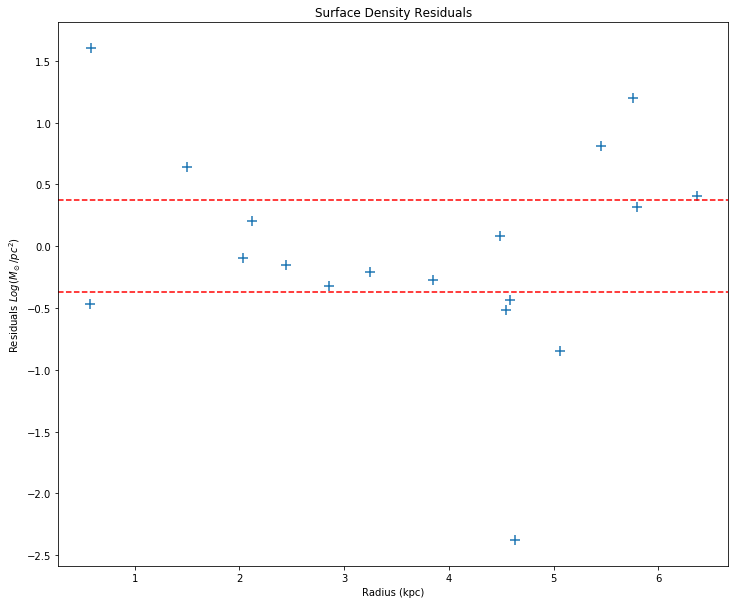

mad(Residual): 0.3706773976155977


In [129]:
### Calculate Surface Densities and Density Profile

surfden = []
for i in range(len(field_masses)):
    surfden.append(np.divide(field_masses[i],field_areas[i]))
    
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

field_list = [np.where(bloopdr16['FIELD']=='30Dor'),np.where(bloopdr16['FIELD']=='LMC1'),
              np.where(bloopdr16['FIELD']=='LMC2'),np.where(bloopdr16['FIELD']=='LMC3'),
              np.where(bloopdr16['FIELD']=='LMC4'),np.where(bloopdr16['FIELD']=='LMC5'),
              np.where(bloopdr16['FIELD']=='LMC6'),np.where(bloopdr16['FIELD']=='LMC7'),
              np.where(bloopdr16['FIELD']=='LMC8'),np.where(bloopdr16['FIELD']=='LMC9'),
              np.where(bloopdr16['FIELD']=='LMC10'),np.where(bloopdr16['FIELD']=='LMC11'),
              np.where(bloopdr16['FIELD']=='LMC12'),np.where(bloopdr16['FIELD']=='LMC13'),
              np.where(bloopdr16['FIELD']=='LMC14'),np.where(bloopdr16['FIELD']=='LMC15'),
              np.where(bloopdr16['FIELD']=='LMC16'),np.where(bloopdr16['FIELD']=='LMC17')]

radii = []

for i in range(len(field_str)):
    radii.append(np.sqrt(np.median(dfunc.LMCdisk_cart(bloopdr16['RA'][field_list[i]],
                                                      bloopdr16['DEC'][field_list[i]])[0])**2 + 
                         np.median(dfunc.LMCdisk_cart(bloopdr16['RA'][field_list[i]],
                                                      bloopdr16['DEC'][field_list[i]])[1])**2))
    

model = np.array([radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(surfden),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(surfden)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

In [105]:
0.101*np.reciprocal(0.61143631**2)

0.2701586780463906

In [68]:
field_masses

[32922504.78638458,
 5235791.9555795435,
 4476266.407626547,
 13833653.180144247,
 56206779.997921914,
 61175256.62210889,
 39690021.68117715,
 24875723.49604724,
 52101396.25089198,
 264285467.5838225,
 24425689.90244778,
 29276313.839029837,
 2929418.777764781,
 49404573.35900116,
 73843791.16896236,
 149006069.71862063,
 6978434.898802554,
 22058411.474356644]

In [76]:
np.reciprocal(0.61143631)

1.6354933190016145

In [89]:
print(radii)
print(surfden)

[0.5869166687148506, 5.449889227474064, 6.366810747083771, 4.49022568506186, 2.8580227825083893, 2.4489567406063633, 3.2512584262520856, 5.05825721763131, 2.1236381055693996, 0.5698757377089569, 4.546676245297748, 3.844773088089841, 5.761527472767706, 1.4997446861929546, 2.0389373659219676, 4.629842827399394, 5.792284032421903, 4.5815268426069595]
[21.38685459477424, 2.4119549517463286, 2.0620668313043278, 8.986507284240302, 36.51259947733853, 39.740181576831965, 25.78311486524016, 16.159568805645392, 33.845692878853065, 171.68301450333962, 15.867221577160644, 19.01824515506637, 1.3494856531186132, 32.09380433237223, 47.969813800759205, 96.79613284250632, 3.2147325089320002, 14.329409073056498]


In [93]:
len(np.delete(radii,0))==len(np.delete(surfden,0))

True

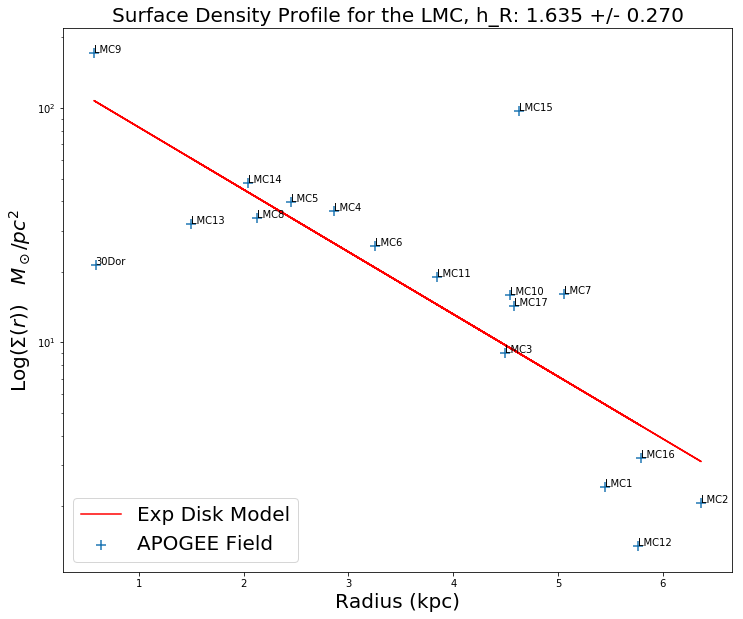

In [124]:
def lmcdensityprofile(r):
    p = [5.02598827, -0.61143631] 
    return p[0]+np.multiply(p[1],r)

plt.figure(figsize=[12,10])

plt.scatter(radii,surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in range(len(radii)):
    plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 
                                              'LMC8','LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
                                              'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title(r'Surface Density Profile for the LMC, h_R: {:.3f} +/- {:.3f}'.format(np.reciprocal(0.61143631),
                                                                                0.101*np.reciprocal(0.61143631**2)),fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile.pdf',bbox_inches='tight')
plt.show()

In [114]:
print(r'scale distance with 30 Dor: ' + str(np.reciprocal(0.61143631)) + r' +/- '+ str(0.101*np.reciprocal(0.61143631**2)))

scale distance with 30 Dor: 1.6354933190016145 +/- 0.2701586780463906


## Remove 30 Dor

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     30.48
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           5.87e-05
Time:                        16:53:51   Log-Likelihood:                -19.433
No. Observations:                  17   AIC:                             42.87
Df Residuals:                      15   BIC:                             44.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3321      0.499     10.677      0.0

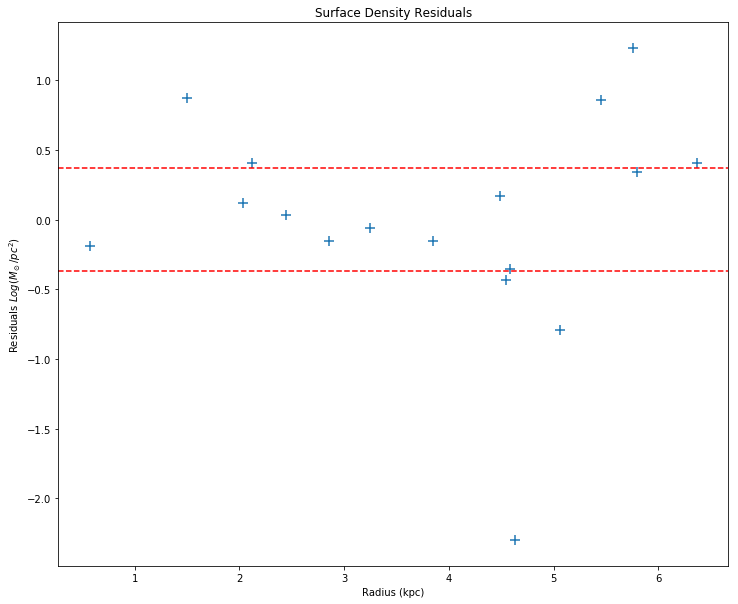

mad(Residual): 0.37231573676865215


In [130]:
radii_rm30dor = np.delete(radii,0)
surfden_rm30dor = np.delete(surfden,0)

model = np.array([radii_rm30dor]).T
model = sm.add_constant(model)
model_model = sm.OLS(np.log(surfden_rm30dor),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(surfden_rm30dor)
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))

plt.figure(figsize=[12,10])
plt.scatter(radii_rm30dor,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(dfunc.mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-dfunc.mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',dfunc.mad(model_residual))

In [104]:
0.120*np.reciprocal(0.66014156**2)

0.27536395820243054

In [101]:
np.reciprocal(0.68644012)

1.4567913075943173

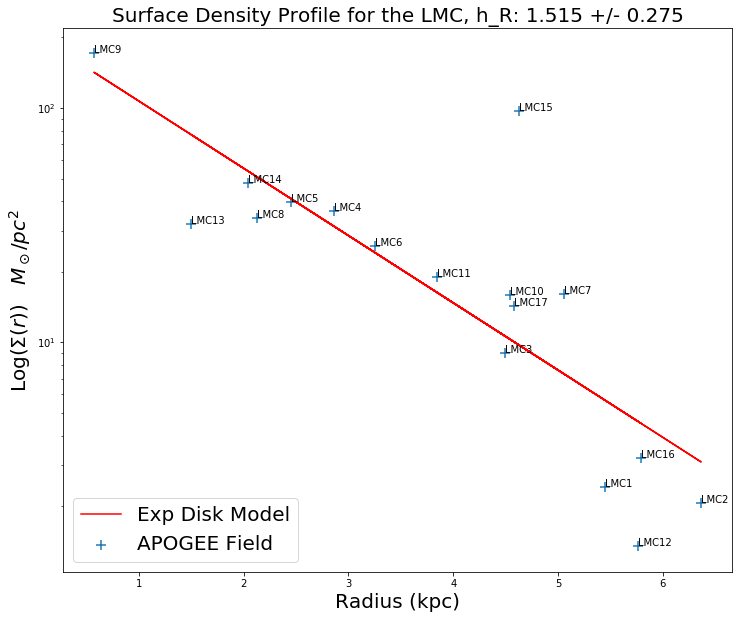

In [138]:
def lmcdensityprofile_rm30dor(r):
    p = [5.33212892, -0.66014156] 
    return p[0]+np.multiply(p[1],r)

plt.figure(figsize=[12,10])

plt.scatter(np.delete(radii,0),np.delete(surfden,0),marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
for i in np.delete(range(len(radii)),0):
    plt.text(radii[i],surfden[i],'{}'.format(['30Dor','LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8',
       'LMC9', 'LMC10', 'LMC11', 'LMC12', 'LMC13', 'LMC14', 'LMC15',
       'LMC16', 'LMC17'][i]))
plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC, h_R: {:.3f} +/- {:.3f}'.format(np.reciprocal(0.66014156),
                                                                                0.120*np.reciprocal(0.66014156**2)),
         fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile_rm30dor.pdf',bbox_inches='tight')
plt.show()

In [113]:
print(r'scale distance without 30 Dor: ' + str(np.reciprocal(0.66014156)) + r' +/- '+ str(0.120*np.reciprocal(0.66014156**2)))

scale distance without 30 Dor: 1.5148266077960613 +/- 0.27536395820243054


In [135]:
print('30 Dor not rm',np.exp(5.02598827))
print('30 Dor rm',np.exp(5.33212892))

30 Dor not rm 152.32071574680347
30 Dor rm 206.87793223986213


In [136]:
np.exp(5.02598827)*0.411

62.60381417193622

In [137]:
np.exp(5.33212892)*0.499

103.2320881876912